## Guo et al. 2022


In [2]:
# imports
import os
import cobra
from cobra.io import read_sbml_model, write_sbml_model
import seaborn as sns
import matplotlib.pylab as plt
from cobra.flux_analysis.parsimonious import pfba 
plt.style.use("seaborn")

import pandas as pd

In [2]:
# Setup paths
_modelPath = '/Users/ampholyt/Coding/BSEP22/Data/Models/iYli21_v1.xml'
_outputDir = '/Users/ampholyt/Coding/BSEP22/Data/ModelAnalysis/'
_modelPrefix = 'iYli21_v1'
_overview = '/ModelOverview/'
_heatDir = '/Heatmaps/'
_condition = 'glu'
# derived paths
_fluxDf = '/Fluxes/{condition}_fluxDf.csv'.format(condition=_condition)
_numbersDf = '/Users/ampholyt/Coding/BSEP22/Data/ModelAnalysis/ModelOverview/{modelPrefix}_modelNumbers.csv'.format(modelPrefix=_modelPrefix)
_defaultFile = '/Users/ampholyt/Coding/BSEP22/Data/ModelAnalysis/ModelOverview/'+ _modelPrefix.split('.')[0] + '_exchangeReactionBounds.csv'

# flags
_verbose = False
_createsOutput = True
_extremlyInterested = False


Structure:
1. Helpful functions
2. Add growth rates in number dataframe
3. Flux values into dataframe (pathway activation pattern)
- Add flux values into dataframe (create)
- Heatmap of this with grouping of pathways
----> Skript Growth rates / Flux
4. Essential genes
- code von Email übernehmen
- Result mit Supplementary data Vergleichen

1. Helper functions:

In [3]:
# helper functions:
def reactionInformationPrint(reactions):
    '''Prints information about the reaction in a readable format'''
    for reaction in reactions:
        print('{name}, (id: {id}) is active. (Bounds: {bounds})'.format(name = reaction.name, id = reaction.id, bounds=reaction.bounds))

def mediumAnalysis(model):
    '''Prints the current active media reactions in a readable format'''
    mediaReactions = []
    print('\n----- media analysis -----')
    for key,value in model.medium.items():
        # search for keys and return names
        mediaReactions.append(model.reactions.get_by_id(key))
    reactionInformationPrint(mediaReactions)
    print('--------------------------')

# Introduce metabolite names into reaction representation
def formulaWithNames(reaction):
    '''Returns the reaction formula with metabolite names instead of ids'''
    formula = reaction.reaction
    for metabolite in reaction.metabolites:
        formula = formula.replace(metabolite.id, metabolite.name)
    return formula

def setReactionBounds(model, boundFile):
    '''Gets a file (expecting at least 2 columns: "reactionId" and "bounds") 
    with bound information for the exchange reactions and sets the corresponding reaction bounds.'''
    for i, reactionId in boundFile['reactionId'].items():
        # get default reaction bounds (eval (tuple))
        reacBounds = eval(boundFile['bounds'][i])
        # get model reaction with reactionid
        modelReaction = model.reactions.get_by_id(reactionId)
        modelReaction.bounds = reacBounds

def setExchangeToZero(model):
    for reaction in model.reactions:
        # find reactions with exchange in reaction name
        if 'exchange' in reaction.name:
            # set bounds to zero
            reaction.bounds = (0.0,0.0)

def exchangeToDefault(model, defaultFile):
    '''Reading default file and setting model to default'''
    print(f'Set reaction bounds from model {model} to default')
    # Read file line by line
    try:
        defaultDf = pd.read_csv(defaultFile)
    except:
        raise Exception('Default values are not defined:\n' + defaultFile + '\nNo such file or directory.')
    # set every exchange reaction to zero: assuming echange in reaction name
    setExchangeToZero(model)
    # set reaction bounds
    setReactionBounds(model,defaultDf)

# useful functions for interacting with metabolite, gene or reaction lists
def getIds(elementList):
    '''Returns the ids of an element list (list of genes, reactions or metabolites'''
    return [elem.id for elem in elementList]

def getNames(elementList):
    '''Returns the names of the elemts in the given list (list of genes, reactions or metabolites'''
    return [elem.name for elem in elementList]

In [4]:
# read model
model = read_sbml_model(_modelPath)

Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled


2. Add growth rates into numbers table

In [5]:
# set conditions according to glucose
exchangeToDefault(model, _defaultFile) # without exchange of carbon

# Set glucose reaction to -2.43 mmol/h (based on Guo et al. 2022)
dGlu = model.reactions.get_by_id('R1070')
dGlu.bounds = (-2.43, 1000)
# mediumAnalysis(model)
pfba_solution = pfba(model)
growthRate = pfba_solution.fluxes.biomass_C
# load numbers dataframe and add growth rate on glucose
numbersDf = pd.read_csv(_numbersDf)
numbersDf['glu_growth'] = [growthRate]
numbersDf.to_csv(_numbersDf)

Set reaction bounds from model M_iYli21 to default


3. Store Flux distribution based on condition

In [6]:
def pFBAofCondition(model, defaultFile, exchangeIds, bounds):
    '''Generartes model and pFBA result based on exchangeIds and bounds'''
    # default exchange condition
    exchangeToDefault(model, defaultFile) # without exchange of carbon
    if (len(exchangeIds) != len(bounds)):
        raise Exception('ExchangeIds and Bounds need to have the same length.')
    # Set bounds of exchange reactions (to -2.43 mmol/h based on Guo et al. 2022)
    for idx in range(len(exchangeIds)):
        exchangeReac = model.reactions.get_by_id(exchangeIds[idx])
        exchangeReac.bounds = bounds[idx]
    return pfba(model)

def createFluxFrame(solution, pathwayDf, outDir, condition):
    '''Creates a new flux Frame based on the available data'''
    fluxSer = solution.fluxes
    fluxDf = pd.DataFrame({'reactionId': fluxSer.index, f'{condition}Flux': fluxSer})
    # merge flux frame with pathway frame
    fluxPathwayDf = fluxDf.merge(pathwayDf, on='reactionId', how='left')
    fluxPathwayDf.to_csv(outDir, index = False)
    return fluxPathwayDf

def addFluxToFrame(solution, outDir, condition):
    '''Adds calculated fluxes into the existing flux frame'''
    fluxDf = pd.read_csv(outDir)
    fluxSer = solution.fluxes
    # needed for the additional series information
    fluxDf.index = fluxDf['reactionId']
    fluxDf[f'{condition}Flux'] = fluxSer
    fluxDf.to_csv(outDir, index = False)
    return fluxDf

def createPathwayFrame(model):
    '''Prepare dataframe from pathway names and reaction ids'''
    pathways = model.groups
    reactionIds = []
    pathwayNames = []
    for pathway in pathways:
        for reaction in pathway.members:
            pathwayNames.append(pathway.name)
            reactionIds.append(reaction.id)
    pathwayDf = pd.DataFrame({'pathway':pathwayNames, 'reactionId':reactionIds})
    return pathwayDf

def extendFluxFrame(model, defaultFile, fluxDfDir, conditionName, exchangeIds, bounds):
    '''Creates or Adds flux data frame based on condition (only one exchangeReaction is possible)'''
    pfba_solution = pFBAofCondition(model, defaultFile, exchangeIds, bounds)
    if os.path.exists(fluxDfDir):
        fluxDf = addFluxToFrame(pfba_solution, fluxDfDir, conditionName)
        return fluxDf
    else:
        # create pathway frame
        pathwayDf = createPathwayFrame(model)
        fluxPathwayDf = createFluxFrame(pfba_solution, pathwayDf, fluxDfDir, conditionName)
    return fluxPathwayDf


## create or add fluxes to fluxes dataframe
fluxDf = extendFluxFrame(model, _defaultFile, _outputDir + _fluxDf, _condition, ['R1070'], [(-2.43,1000)])

Set reaction bounds from model M_iYli21 to default


### Visualisation of (filtered) flux values and reactions
1. Filter flux values
2. Heatmaps 
- a) filtered fluxes (ordered by flux)
- b) summaries for each pathway
- c) overview over pathways used (heatmap for each pathway)


/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/ipykernel_5410/2954759707.py:75: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meanPathwayFlux = filteredFlux.groupby('pathway').mean()


UnboundLocalError: local variable 'filteredFlux' referenced before assignment

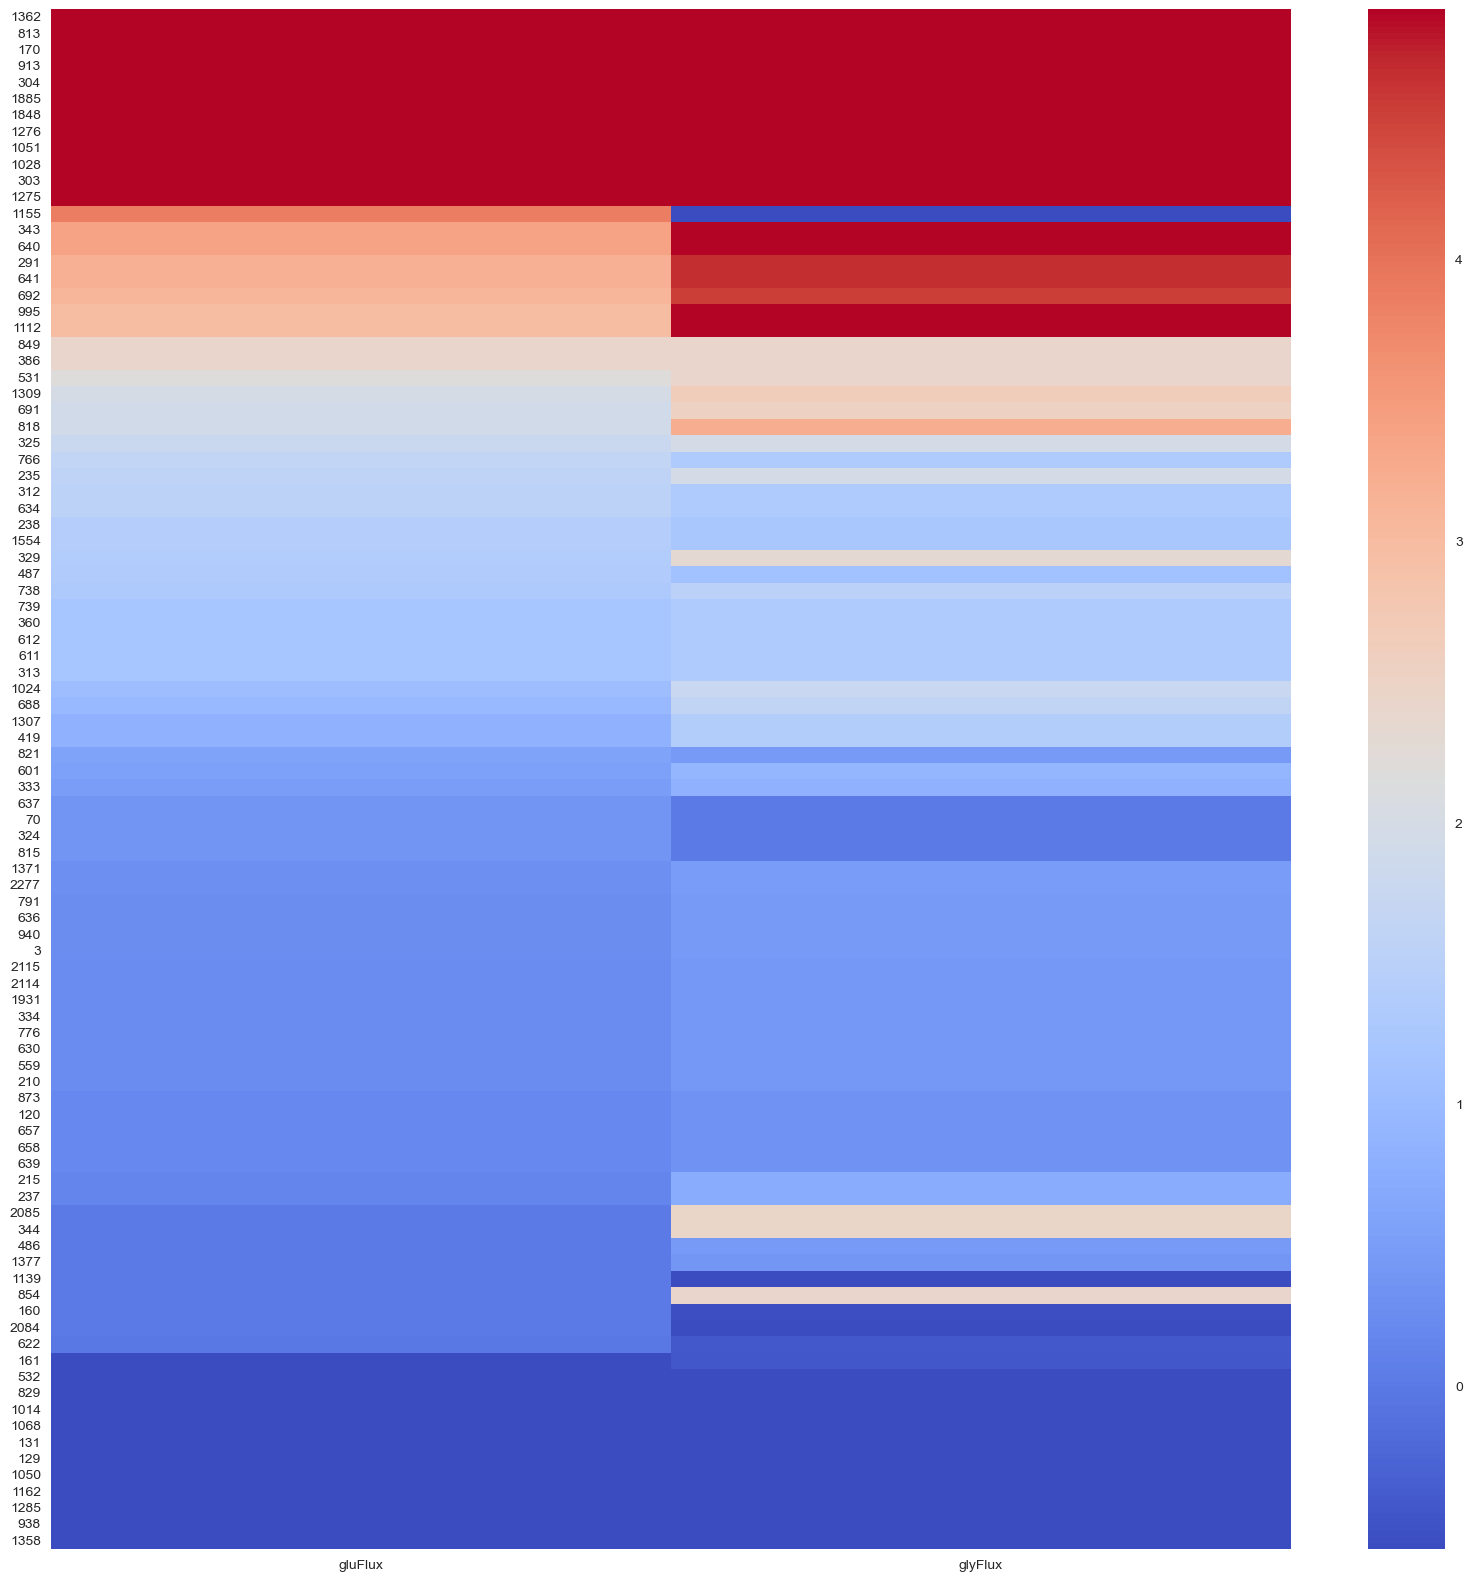

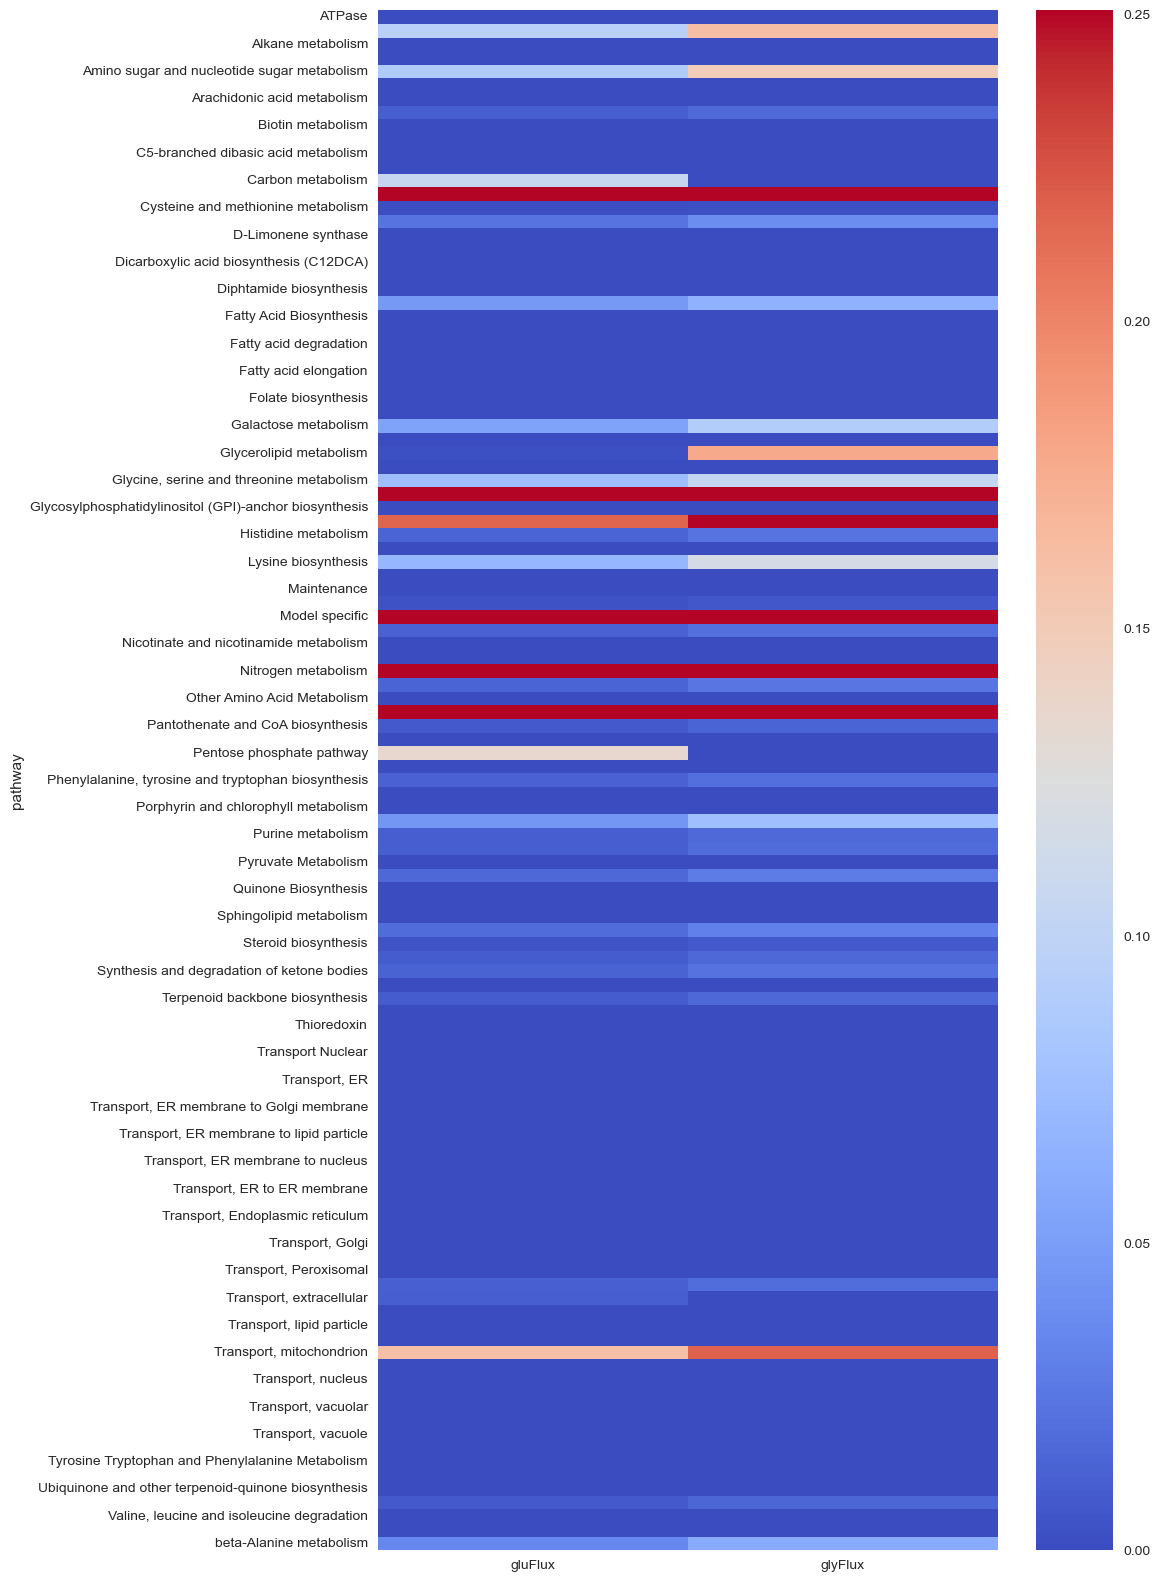

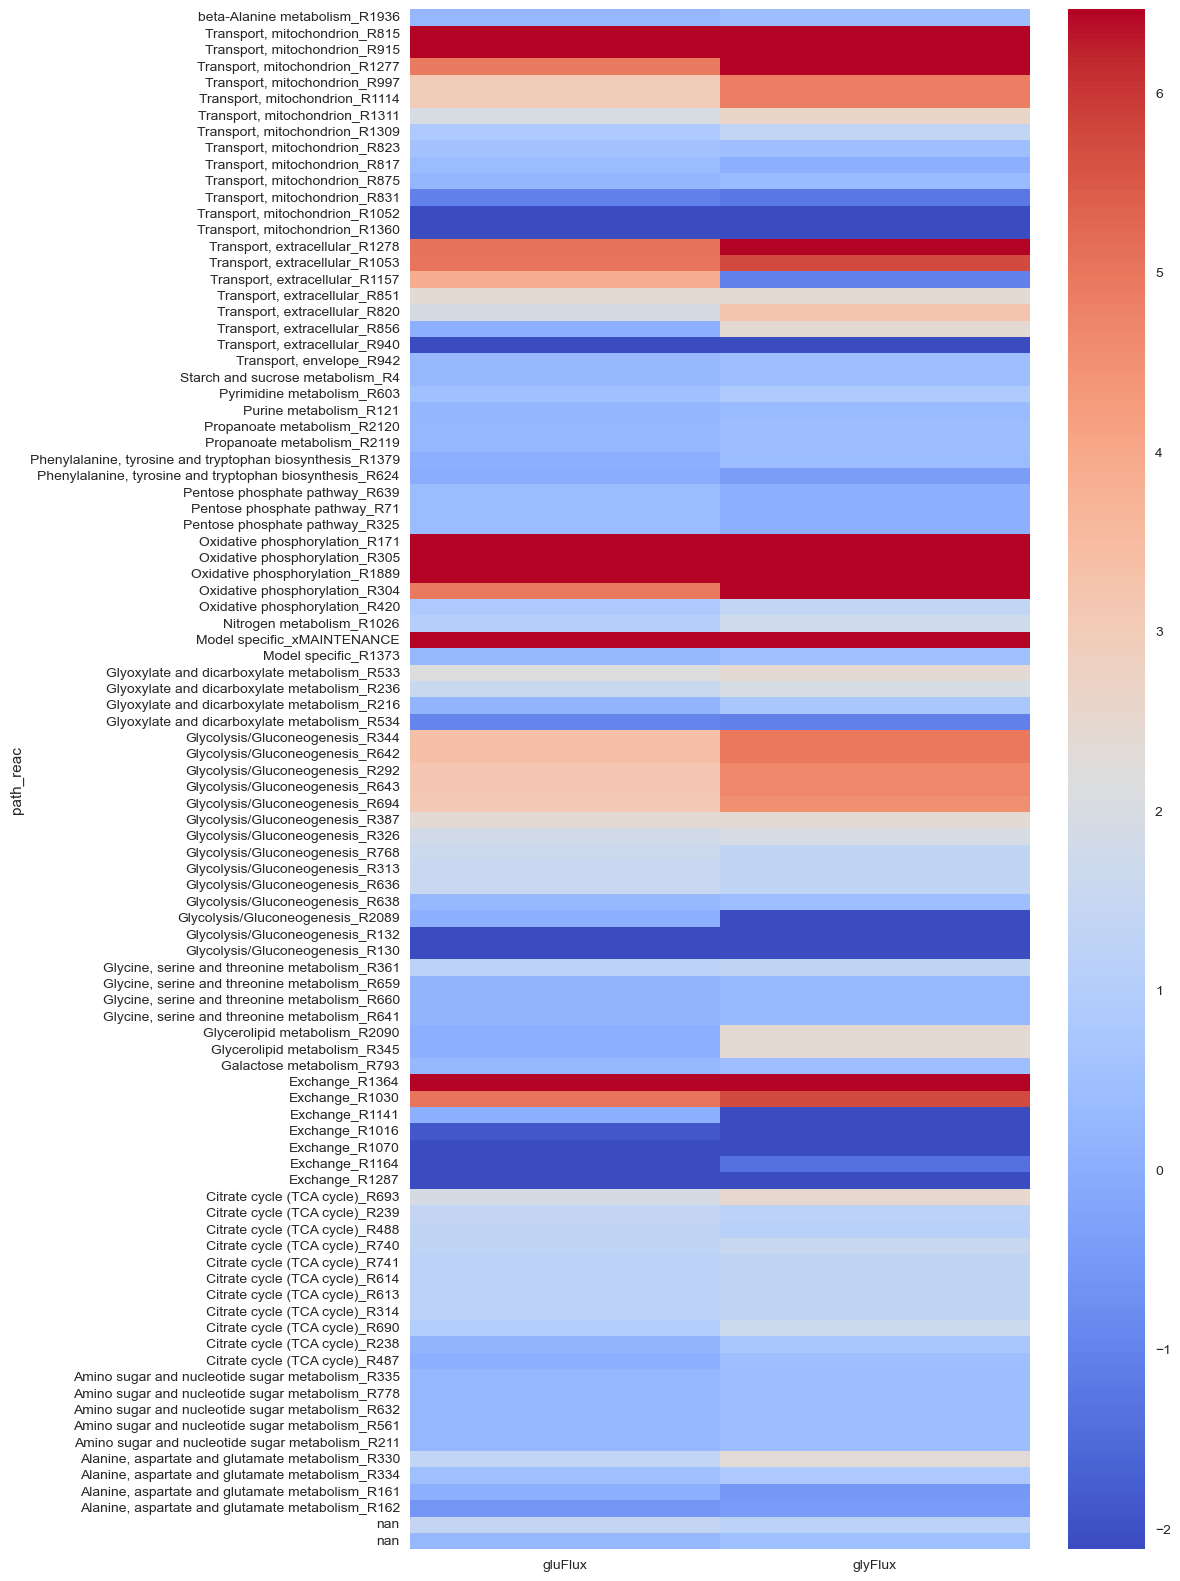

In [110]:
# This skript will load the flux frame file (flux distributions for all reactions) for all conditions of one Model.
# It will visualize the results of filtering based on user specified values. (Heatmaps)
# expecting fluxVisluaization.py model=<model>(req) prefix=<modelPrefix> cond=<condition>(req) flux=<fluxFrame>(req) filter=<filterThreshold> <outputDir>(req)

# imports:
import cobra
from cobra.io import read_sbml_model
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# default: 
_modelPath = '/Users/ampholyt/Coding/BSEP22/Data/Models/iYli21_v1.xml'
_outputDir = '/Users/ampholyt/Coding/BSEP22/Data/ModelAnalysis/'
_heatDir = '/Heatmaps/'
_fluxDir = '/Fluxes/'
_modelPrefix = 'iYli21_v1'
_conditions = ['glu','gly']
_fluxDf = _outputDir + f'/Fluxes/{_modelPrefix}_fluxDf.csv'
_cmap = 'coolwarm'

print("Warning: This script assumes in step 'heatmap for each pathway' so called interestingPathways which are model specific.")

# setup:
# sys.argv = ['fluxVisualization.py', 'model=iYli21_v1', 'prefix=iYli21_v1', 'cond=glu', 'flux=/Users/ampholyt/Coding/BSEP22/Data/ModelAnalysis/Fluxes/glu_fluxDf.csv', 'filter=0.1', 'outdir=/Users/ampholyt/Coding/BSEP22/Data/ModelAnalysis/']

# argCounter = 0
# for arg in sys.argv:
#     if 'model=' in arg:
#         _modelPath = arg.split('=')[1]
#         argCounter += 1
#     elif 'prefix=' in arg:
#         _modelPrefix = arg.split('=')[1]
#     elif 'cond=' in arg:
#         _conditions = arg.split('=')[1].split(',')
#         argCounter += 1
#     elif 'flux=' in arg:
#         _fluxDf = arg.split('=')[1]
#         argCounter += 1
#     elif 'filter=' in arg:
#         _filterThreshold = float(arg.split('=')[1])
#     elif 'outdir=' in arg:
#         _outputDir = arg.split('=')[1]
#         _heatDir = _outputDir + '/Heatmaps/'
#         argCounter += 1
    
# if argCounter < 4:
#     raise Exception('Not enough arguments provided. Please provide at least model, condition, fluxDf and outputDir.')

# _fluxDf = '/Users/ampholyt/Coding/BSEP22/Data/ModelAnalysis/Fluxes/glu_fluxDf.csv'


# load helper functions

def filteredFlux(fluxDf, filterThreshold, outputDir, modelPrefix, conditionList):
    # heatmap of filtered flux
    filteredFlux = fluxDf.copy()
    # max flux value
    filteredFlux['maxValues'] = filteredFlux.filter(like='Flux').abs().max(axis=1)
    # filter fluxes
    filteredFlux = filteredFlux[filteredFlux['maxValues'] > filterThreshold]

    # heatmap with vmin and vmax based on quantil values (max of 85-quantil, min of 15-quantil)
    # sort by flux of first condition
    filteredFlux = filteredFlux.sort_values(by=f'{conditionList[0]}Flux', ascending=False)
    # create heatmap
    plt.figure(figsize=(20,20))
    sns.heatmap(filteredFlux.filter(like='Flux'), vmin=filteredFlux.filter(like='Flux').quantile(0.15).min(), vmax=filteredFlux.filter(like='Flux').quantile(0.85).max(), cmap=_cmap)
    plt.savefig(outputDir + _heatDir + modelPrefix + '_filteredFluxHeatmap.png')
    return filteredFlux


def summarizePathwayFlux(filteredFlux, outputDir, modelPrefix, conditionList):
    # summarize fluxes by pathway (average/median)
    meanPathwayFlux = filteredFlux.groupby('pathway').mean()
    # set vmin vmax accordingly qanVal
    minFlux = meanPathwayFlux.filter(like='Flux').quantile(0.05).min()
    maxFlux = meanPathwayFlux.filter(like='Flux').quantile(0.95).max()
    plt.subplots(figsize=(10, 20))
    sns.heatmap(meanPathwayFlux, cmap=_cmap, vmin=minFlux, vmax=maxFlux)
    plt.savefig(outputDir + _heatDir + modelPrefix + '_meanPathwayFluxHeatmap.png')
    return meanPathwayFlux


def reacPathwayHeatmap(filteredFluxDf, outputDir, modelPrefix, conditionList):
    # c.1) sort fluxes by pathway and flux values
    # check for specific pathways
    pathwayGroup = filteredFluxDf.sort_values(by=['pathway', f'{conditionList[0]}Flux'], ascending=False)
    pathwayGroup['path_reac'] = pathwayGroup['pathway'] + '_' + pathwayGroup['reactionId']
    pathwayGroup.index = pathwayGroup['path_reac']
    minVal = pathwayGroup.filter(like='Flux').quantile(0.10).min()
    maxVal = pathwayGroup.filter(like='Flux').quantile(0.90).max()
    plt.subplots(figsize=(10, 20))
    sns.heatmap(pathwayGroup.filter(like='Flux'), cmap=_cmap, vmin=minVal, vmax=maxVal)
    plt.savefig(outputDir + _heatDir + modelPrefix + '_filteredPathwayReacHeatmap.png')
    return pathwayGroup

def heatmapPerPathway(filteredFluxDf, outputDir, modelPrefix, conditionList, filterThreshold=0.03):
    '''Generates Heatmaps for each pathway and returns a list of unused pathway and the reactions per pathway'''
    # filter flux values for absolute fluxes > 0.03 / filterThreshold (for 0.03 there will be 187 reactions)
    filteredFlux['absVal'] = filteredFlux.filter(like='Flux').abs()
    filteredFlux = filteredFlux[filteredFlux['absFlux'] > filterThreshold]
    filteredFlux.drop(columns=['absFlux'], inplace=True)
    print(f'Number of reactions with absolute flux > {filterThreshold}: {len(filteredFlux)}') 
    filteredMeanVal = filteredFlux.filter(like='Flux').mean()
    filteredStd = filteredFlux.filter(like='Flux').std()
    plotMax = filteredMeanVal + filteredStd 
    plotMin = filteredMeanVal - filteredStd
    print("max", plotMax)
    print("min", plotMin)
    fixx all the errors
    # # interesting pathways are probably model specific
    # interestingPathwaySubset = ["Amino acid metabolism", "Citrate cycle (TCA cycle)", "Exchange", "Fatty acid metabolism", "Glycerolipid metabolism", "Glycolysis/Gluconeogenesis", "Pentose phosphate pathway", "Transport"]
    # unusedPathways = [] # for interested users or later analysis
    # reactionsPerGroup = {}
    # # iterate over interesting groups and prepare a heatmap for each group
    # for group in interestingPathwaySubset:
    #     if (group not in filteredFlux['pathway'].unique()):
    #         unusedPathways.append(group)
    #         continue
    #     # filter for group
    #     groupFlux = filteredFlux[filteredFlux['pathway'] == group]
    #     reactionsPerGroup[group] = len(groupFlux)
    #     # sort by flux
    #     groupFlux = groupFlux.sort_values(by=[f'{conditionList[0]}Flux'], ascending=False)
    #     # create heatmap
    #     minVal = groupFlux.filter(like='Flux').quantile(0.01).min()
    #     maxVal = groupFlux.filter(like='Flux').quantile(0.99).max()
    #     fig, ax = plt.subplots(figsize=(20, 10))
    #     sns.heatmap(groupFlux.filter(like='Flux'), cmap=_cmap, annot=True, fmt='.2f', vmin=minVal, vmax=maxVal)
    #     # sns.heatmap(groupFlux.filter(like='Flux'), cmap=_cmap, annot=True, fmt='.2f', vmin=-5, vmax=5)
    #     ax.set_title(group)
    #     # plt.save
    #     plt.show()

    # print(f'unused Pathways: {unusedPathways}')
    # return reactionsPerGroup, unusedPathways

def main():
    # read model
    model = read_sbml_model(_modelPath)

    # load flux frame
    fluxDf = pd.read_csv(_fluxDf, sep=';')
    # check output dir for heatmaps:
    if not os.path.exists(_outputDir + _heatDir):
        os.makedirs(_outputDir + _heatDir)
    # heatmap of filtered flux
    filteredFluxDf = filteredFlux(fluxDf, 0.3, _outputDir, _modelPrefix, _conditions)
    # heatmap for summarised flux for each pathway
    meanPathwayFluxDf = summarizePathwayFlux(fluxDf, _outputDir, _modelPrefix, _conditions)
    # Heatmap for pathways used
        
    # -> Pathway + Reaction heatmap
    pathwayGroupDf = reacPathwayHeatmap(filteredFluxDf, _outputDir, _modelPrefix, _conditions)
    # -> Heatmap for each pathway (0.03 -> 187 reactions)
    reactionPerPathway, unusedPathways = heatmapPerPathway(filteredFluxDf, _outputDir, _modelPrefix, _conditions, 0.03)
    # -> Heatmap for overview on pathways used (pathways x reactions)
    
    # Correlation between number of reactions per group and average pathway flux

if __name__ == '__main__':
    main()

#### a) Heatmap of filtered fluxes

In [27]:
test = pd.read_csv('/Users/ampholyt/Coding/BSEP22/Data/ModelAnalysis/Fluxes/glu_fluxDf.csv', sep=';')
test.head()
asdf = test.filter(like='Flux', axis=1)
asdf
asdf = test.filter(like='Flux', axis=1).quantile(0.95)
asdf
filterThreshold = 0.3
# filter multiple columns of test based on filterThreshold
tmp = test.filter(like='Flux', axis=1).apply(lambda x: x if x > filterThreshold else 0)
tmp
type(tmp)

pandas.core.frame.DataFrame

95% quantile of fluxes: 0.06493139132612463
Max flux: 16.626547954315626
Min flux: -20.19925620821028
Number of reactions with absolute flux > 0.1: 64
95% quantile of filtered fluxes: 13.005253908272978


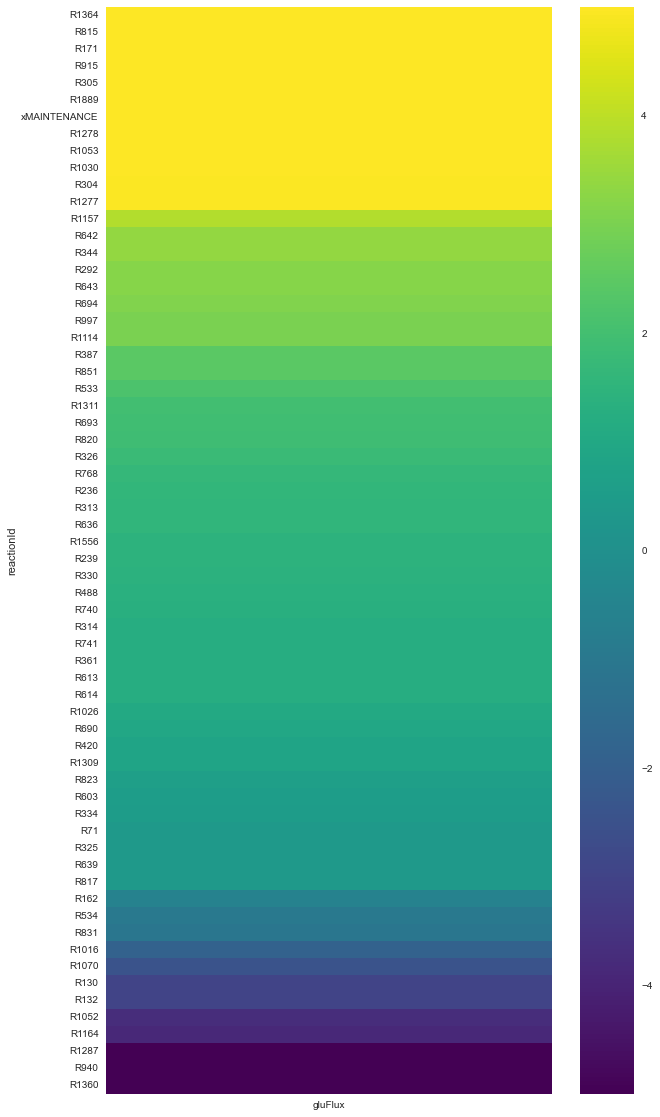

In [7]:
#### a) filtered fluxes
_filterThreshold = 0.3
filteredFlux = fluxDf.copy()

# calculate max, min and 95% percentil of fluxes
quantileVal = fluxDf[f'{_condition}Flux'].quantile(0.95)
maxFlux = fluxDf[f'{_condition}Flux'].max()
minFlux = fluxDf[f'{_condition}Flux'].min()
print(f'95% quantile of fluxes: {quantileVal}\nMax flux: {maxFlux}\nMin flux: {minFlux}')

# filter flux values for absolute fluxes > _filterThreshold
filteredFlux['absFlux'] = filteredFlux[f'{_condition}Flux'].abs()
filteredFlux = filteredFlux[filteredFlux['absFlux'] > _filterThreshold]
filteredFlux.drop(columns=['absFlux'], inplace=True)
print(f'Number of reactions with absolute flux > {_filterThreshold}: {len(filteredFlux)}')
filteredQuantileVal = filteredFlux[f'{_condition}Flux'].quantile(0.95)
print(f'95% quantile of filtered fluxes: {filteredQuantileVal}')
# a) heatmap of ordered filtered fluxes
# order by flux
filteredFlux = filteredFlux.sort_values(by=f'{_condition}Flux', ascending=False)

# set vmin vmax accordingly qanVal
plt.subplots(figsize=(10, 20))
sns.heatmap(filteredFlux[[f'{_condition}Flux']], cmap=_cmap, vmin=-5, vmax=5)
plt.show()


#### b) summaries for each pathway

/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/ipykernel_6022/3022673699.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  meanPathwayFlux = filteredFlux.groupby('pathway').mean()


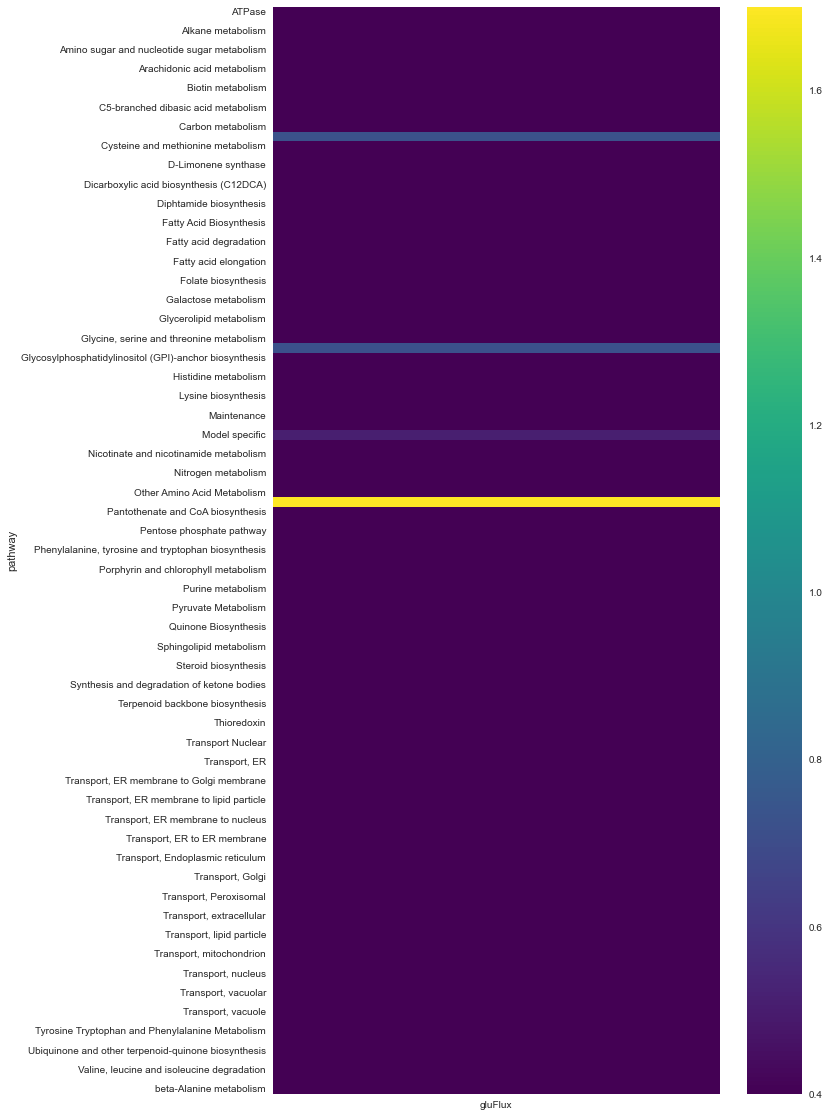

In [8]:
# summarize fluxes by pathway (average/median)
filteredFlux = fluxDf.copy()
meanPathwayFlux = filteredFlux.groupby('pathway').mean()
# set vmin vmax accordingly qanVal
plt.subplots(figsize=(10, 20))
sns.heatmap(meanPathwayFlux, cmap=_cmap, vmin=0.4, vmax=1.7)
plt.show()

#### c) overview over pathways used
 

##### c.1) heatmap for pathway + reaction


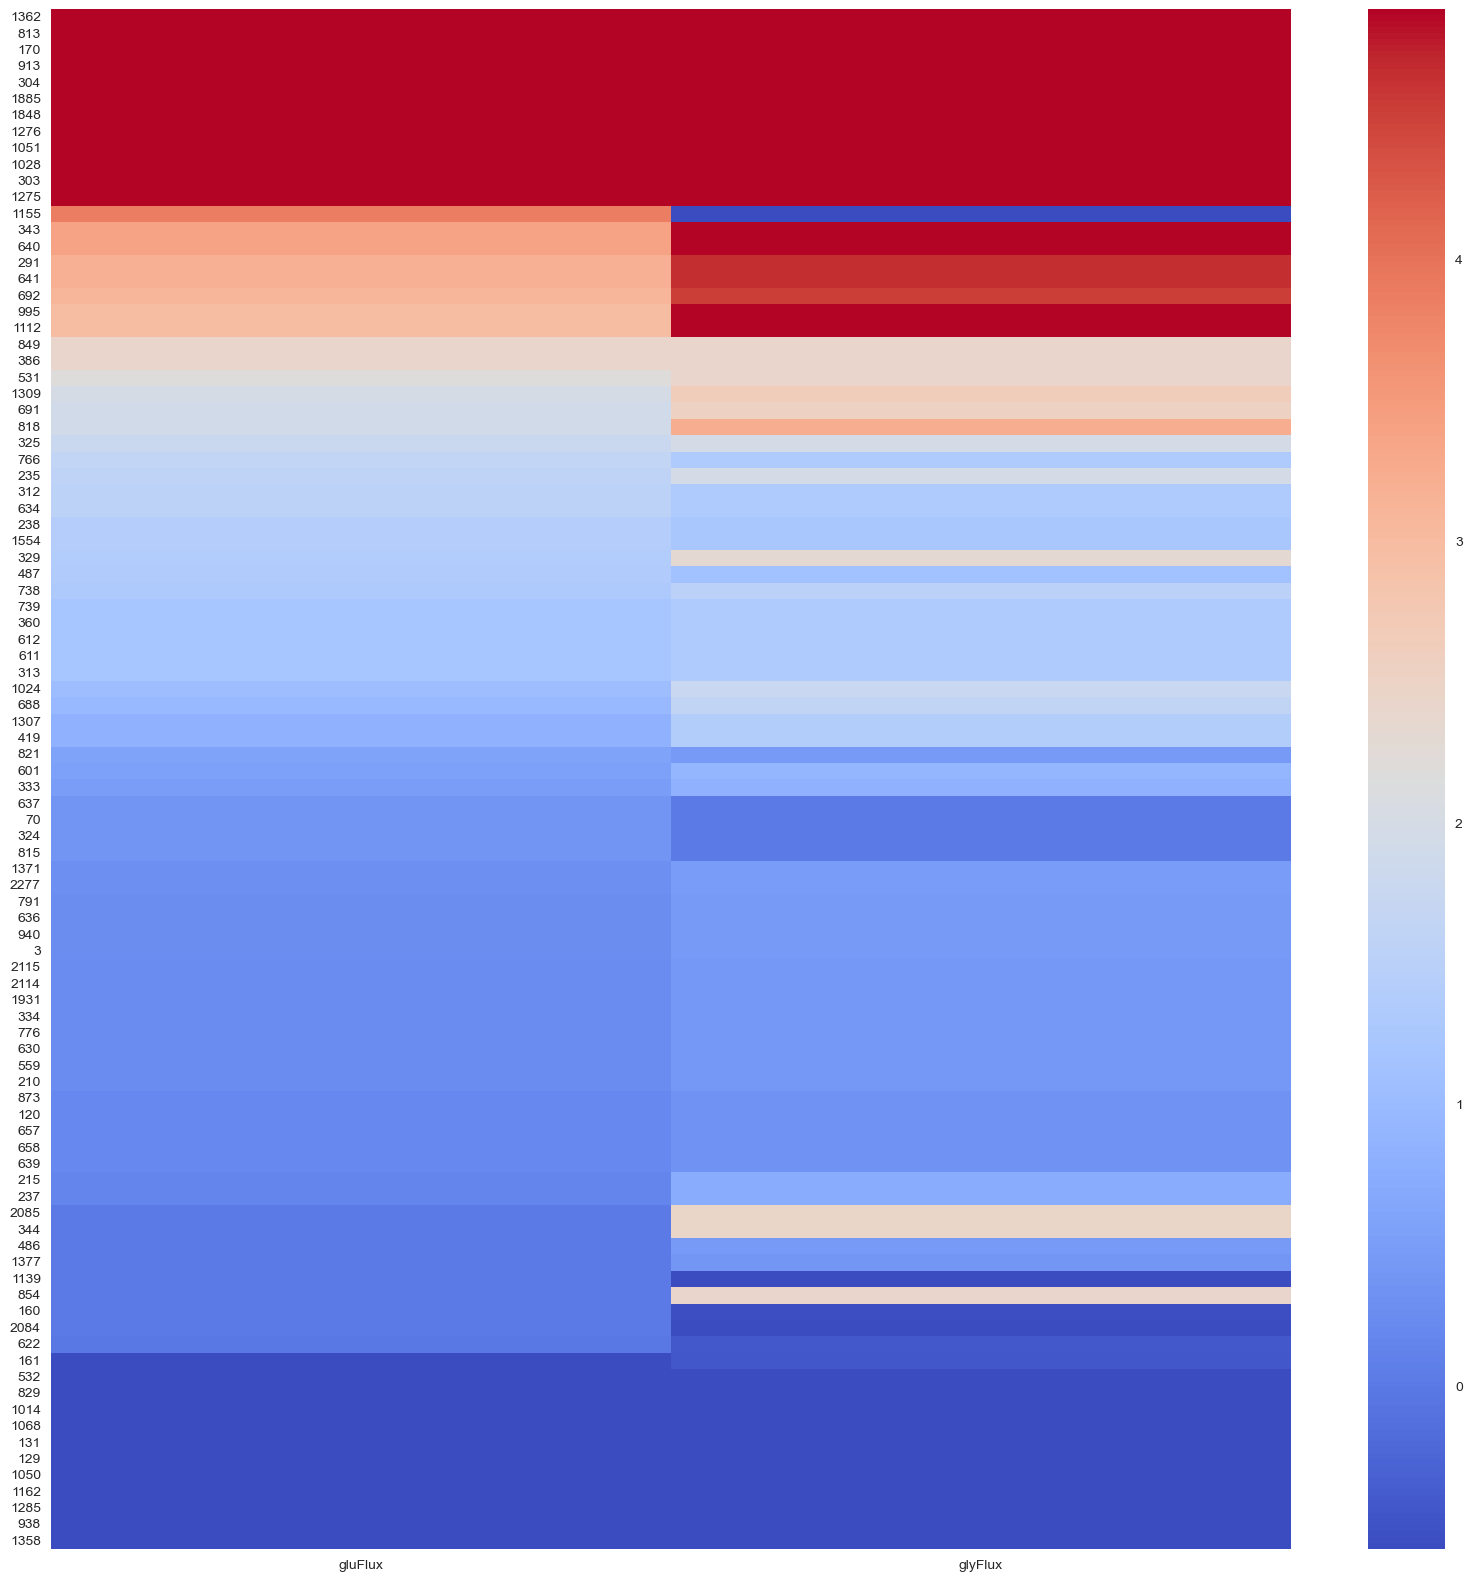

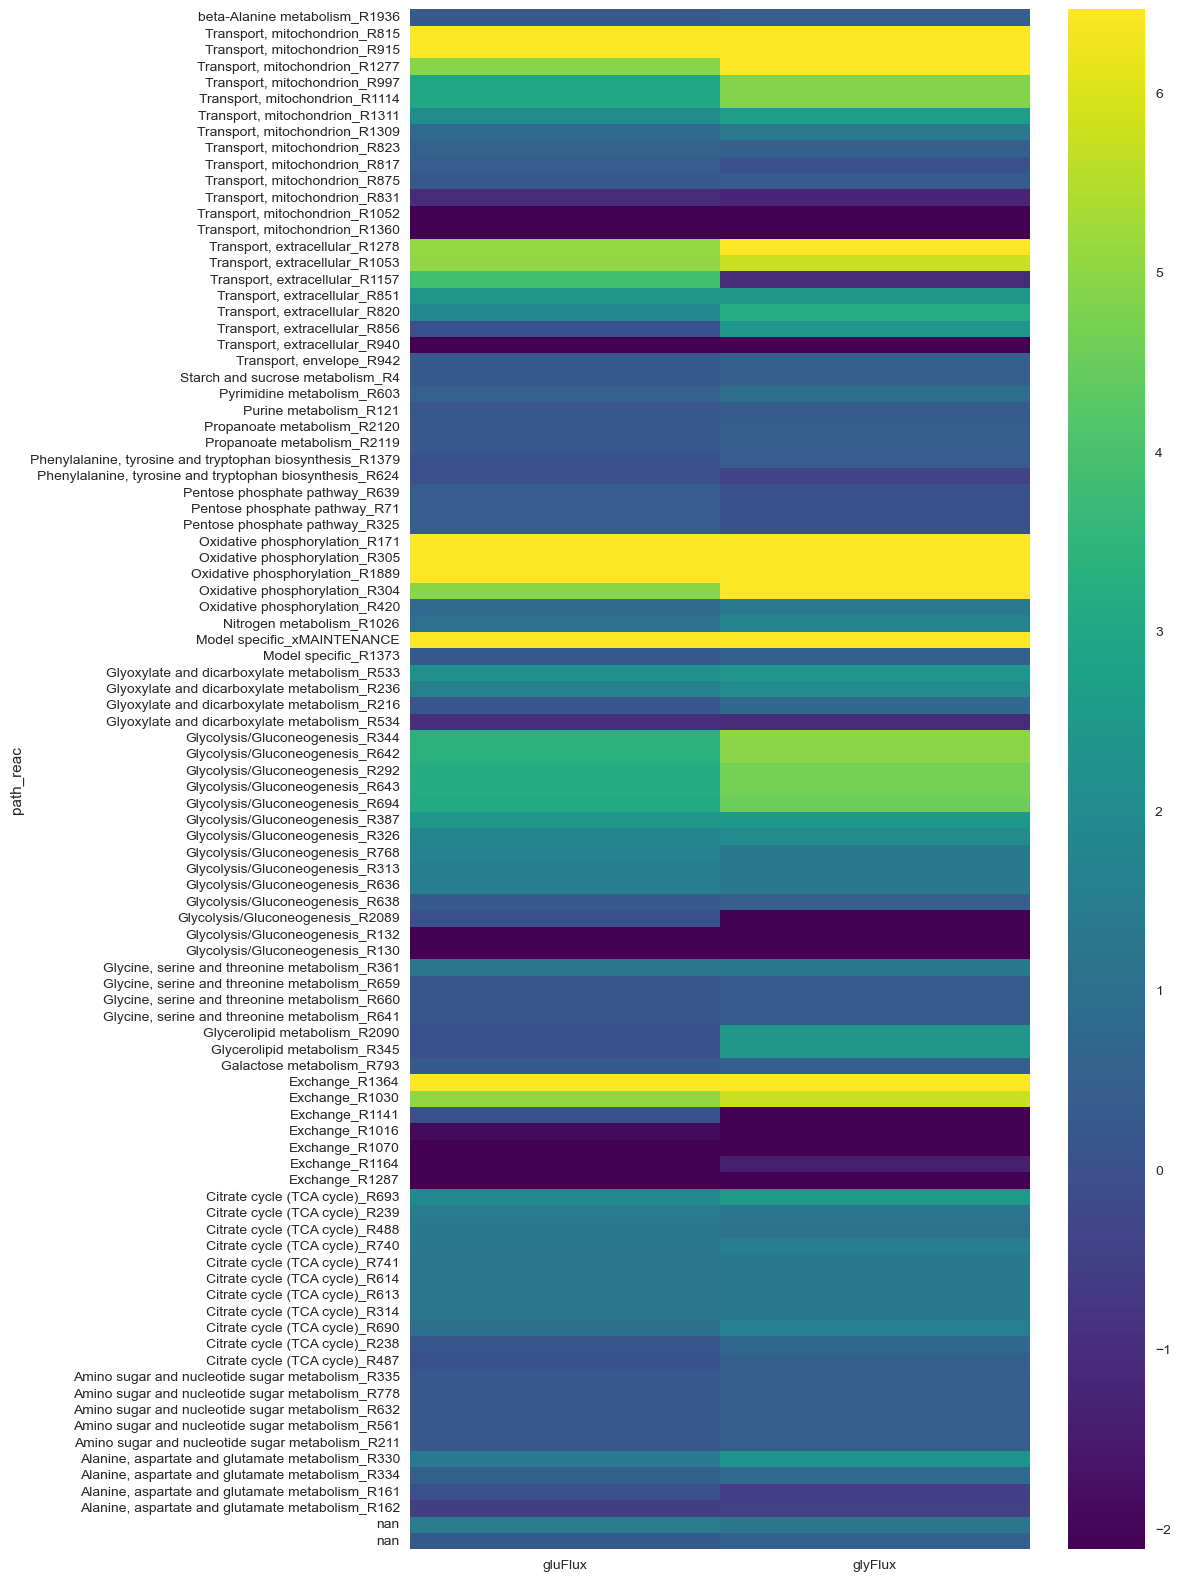

In [89]:
fluxDf = pd.read_csv(_fluxDf, sep=';')
filteredFluxDf = filteredFlux(fluxDf, 0.3, _outputDir, _modelPrefix, _condition)
# c.1) sort fluxes by pathway and flux values
# check for specific pathways
pathwayGroup = filteredFluxDf.sort_values(by=['pathway', f'{_condition[0]}Flux'], ascending=False)
pathwayGroup['path_reac'] = pathwayGroup['pathway'] + '_' + pathwayGroup['reactionId']
pathwayGroup.index = pathwayGroup['path_reac']
minVal = pathwayGroup.filter(like='Flux').quantile(0.10).min()
maxVal = pathwayGroup.filter(like='Flux').quantile(0.90).max()
plt.subplots(figsize=(10, 20))
sns.heatmap(pathwayGroup.filter(like='Flux'), cmap=_cmap, vmin=minVal, vmax=maxVal)
plt.show()

##### c.2) heatmap for each pathway

Number of reactions with absolute flux > 0.1: 187
95% quantile of filtered fluxes: 0.6667589107333542
3.3451937991684964
95% quantile of filtered fluxes: 0.6667589107333542


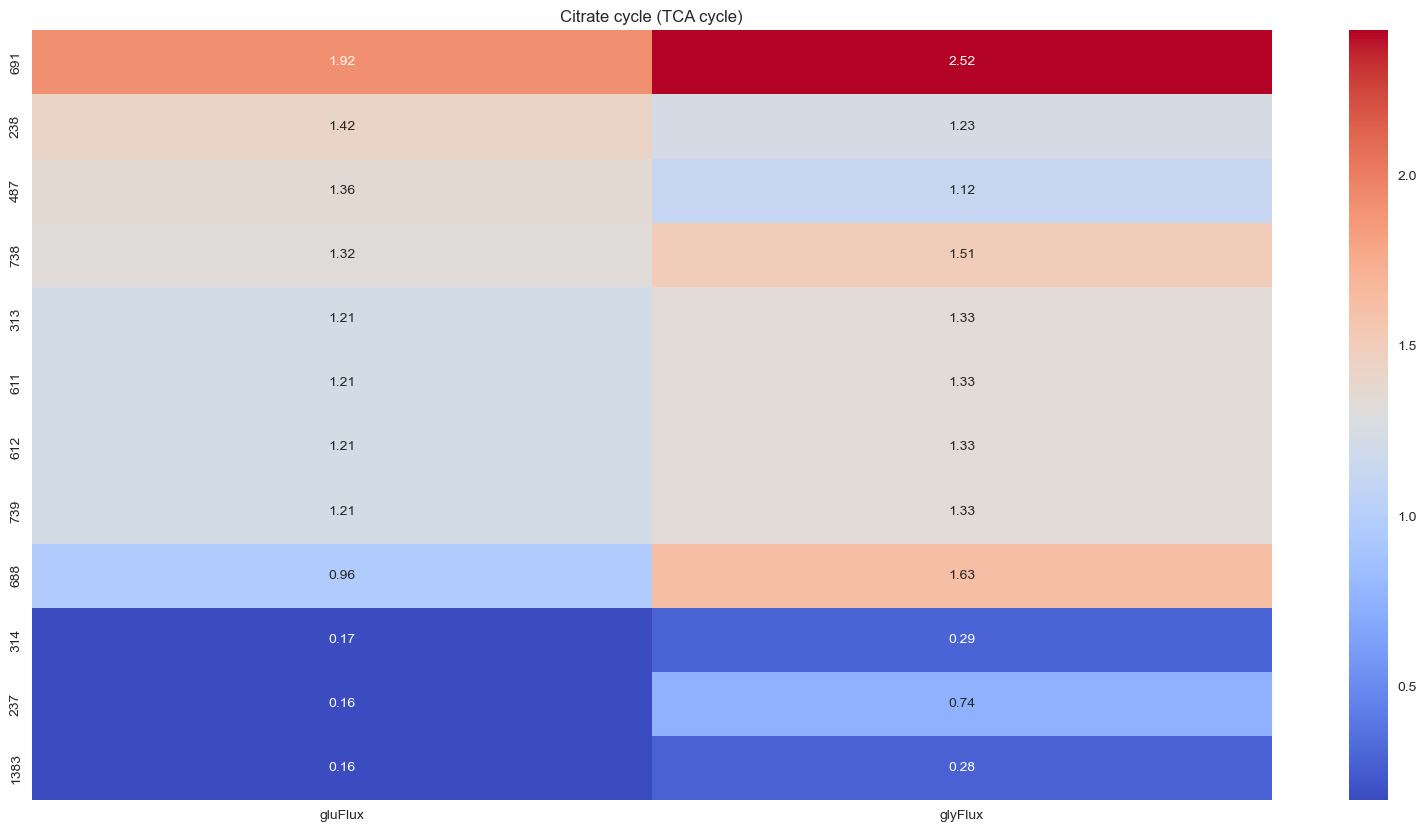

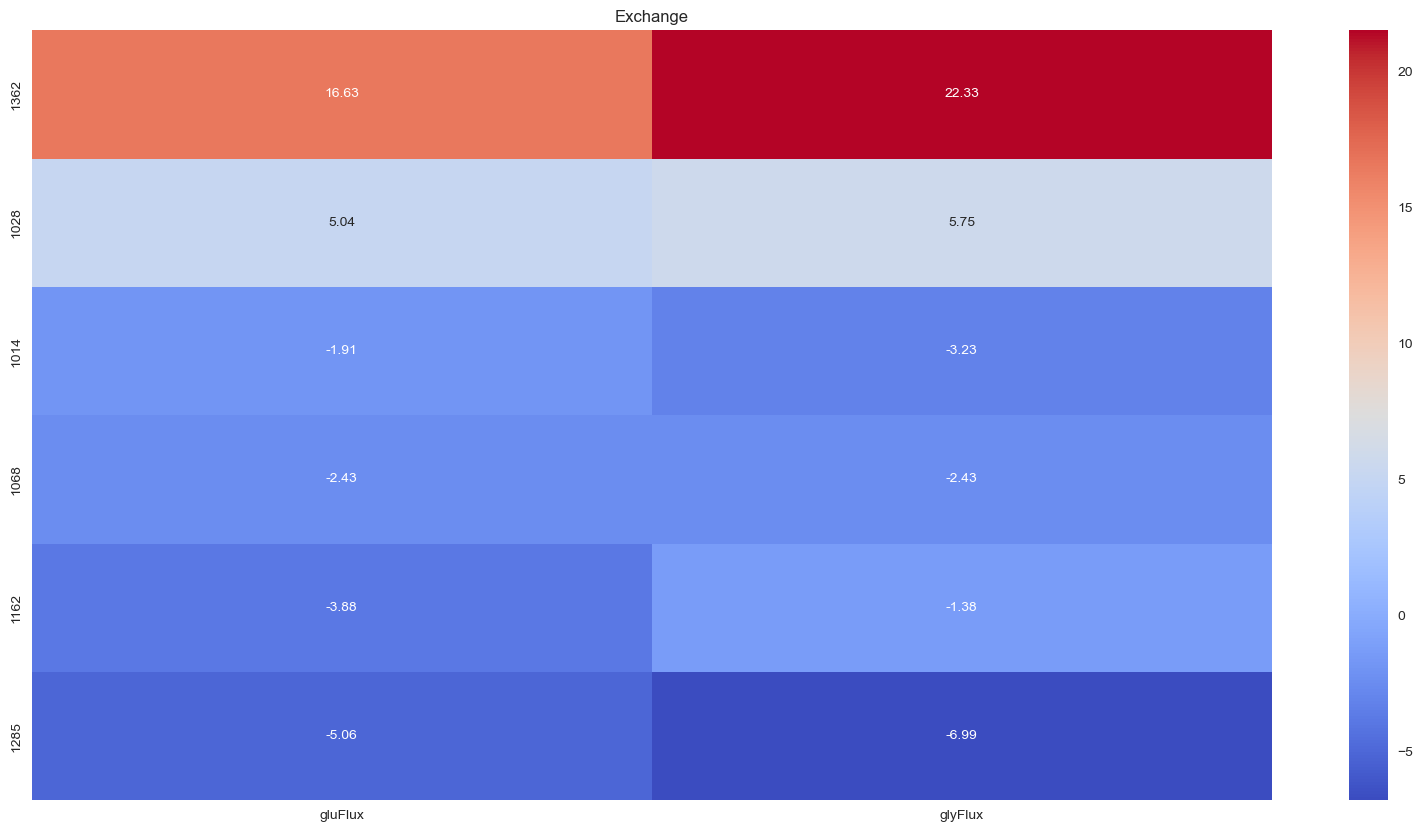

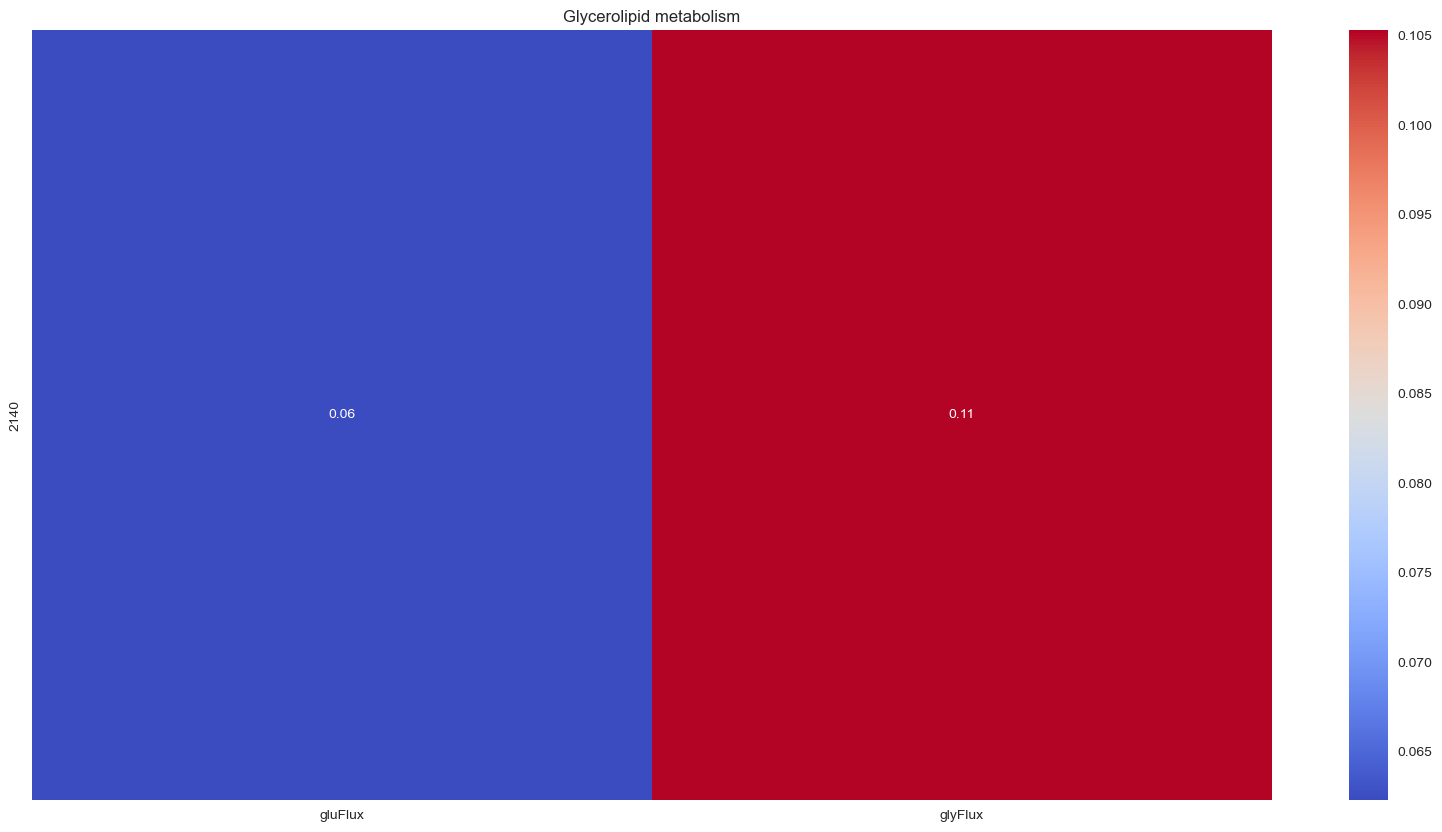

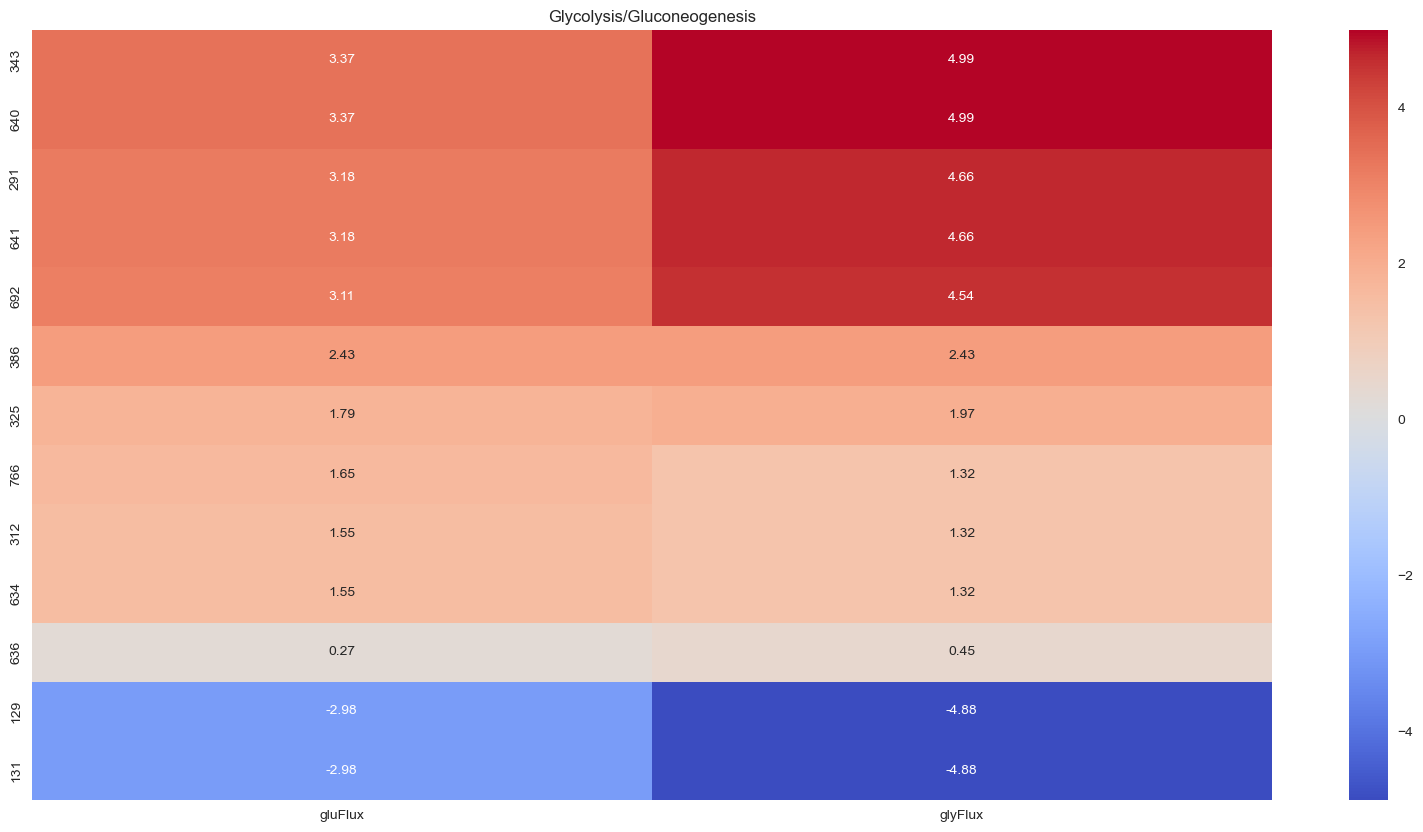

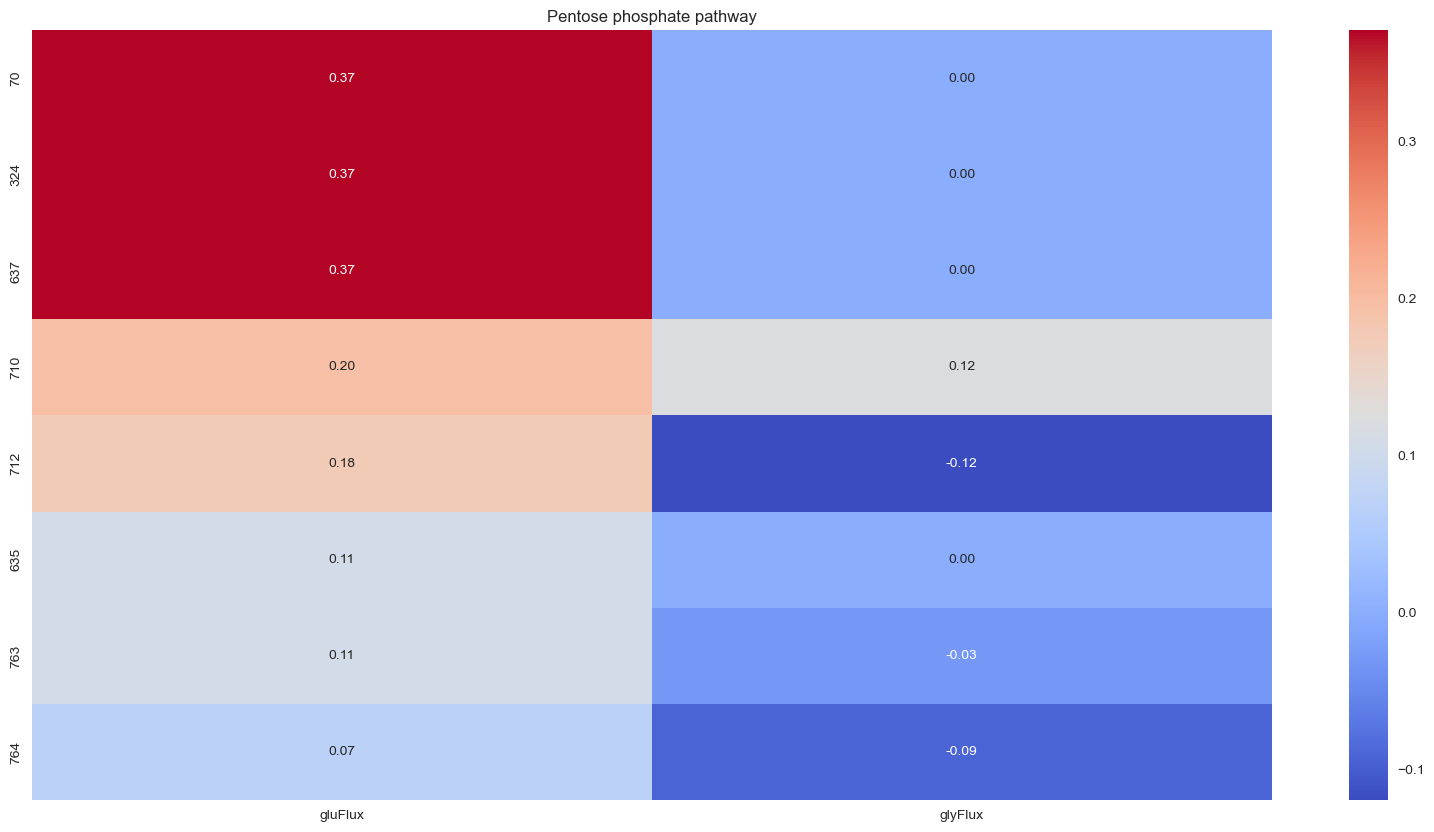

unused Pathways: ['Amino acid metabolism', 'Fatty acid metabolism', 'Transport']


In [108]:
filteredFlux = fluxDf.copy()
# c.2) heatmap for each pathway
# introduce threshold for filtering
# filter flux values for absolute fluxes > 0.03
filteredFlux['absFlux'] = filteredFlux[f'{_condition[0]}Flux'].abs()
filteredFlux = filteredFlux[filteredFlux['absFlux'] > 0.03]
filteredFlux.drop(columns=['absFlux'], inplace=True)
print(f'Number of reactions with absolute flux > 0.1: {len(filteredFlux)}')
filteredQuantileVal = filteredFlux[f'{_condition[0]}Flux'].mean()
print(f'95% quantile of filtered fluxes: {filteredQuantileVal}')
filteredStd = filteredFlux[f'{_condition[0]}Flux'].std()
print(filteredStd)
print(f'95% quantile of filtered fluxes: {filteredQuantileVal}')
interestingPathwaySubset = ["Amino acid metabolism", "Citrate cycle (TCA cycle)", "Exchange", "Fatty acid metabolism", "Glycerolipid metabolism", "Glycolysis/Gluconeogenesis", "Pentose phosphate pathway", "Transport"]
# need to search for interestingPathwaySubset for each model
unusedPathways = []
reactionsPerGroup = {}
# iterate over interesting groups and prepare a heatmap for each group
for group in interestingPathwaySubset:
    if (group not in filteredFlux['pathway'].unique()):
        unusedPathways.append(group)
        continue
    # filter for group
    groupFlux = filteredFlux[filteredFlux['pathway'] == group]
    reactionsPerGroup[group] = len(groupFlux)
    # sort by flux
    groupFlux = groupFlux.sort_values(by=[f'{_condition[0]}Flux'], ascending=False)
    # create heatmap
    minVal = groupFlux.filter(like='Flux').quantile(0.01).min()
    maxVal = groupFlux.filter(like='Flux').quantile(0.99).max()
    fig, ax = plt.subplots(figsize=(20, 10))
    sns.heatmap(groupFlux.filter(like='Flux'), cmap=_cmap, annot=True, fmt='.2f', vmin=minVal, vmax=maxVal)
    # sns.heatmap(groupFlux.filter(like='Flux'), cmap=_cmap, annot=True, fmt='.2f', vmin=-5, vmax=5)
    ax.set_title(group)
    # plt.save
    plt.show()

print(f'unused Pathways: {unusedPathways}')

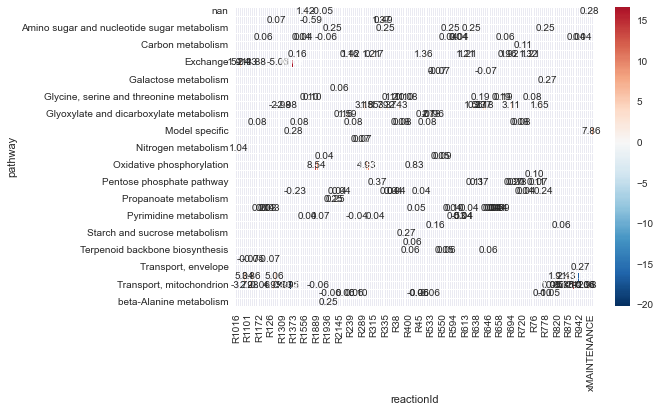

In [11]:
# c.3) heatmap for overview on used pathways
fluxPathwayDf_pivot = filteredFlux.pivot(index='pathway', columns='reactionId', values=f'{_condition}Flux')

sns.heatmap(fluxPathwayDf_pivot, cmap='RdBu_r', center=0, linewidths=0.5, annot=True, fmt='.2f')
plt.show()

### Correlation between Reactions per group and average Pathway flux

In [12]:
# Correlation between number of reactions per group and average pathway flux
from sklearn.linear_model import LinearRegression
# print(f'reactions per group: {reactionsPerGroup}')

## finde unterschiede in den groups (Woher kommen die?)
# X = number of reactions per group (dict durchgehen)
# y = average pathway flux (meanPathwayFlux) (dict durchgehen und dabei auch diese hier schnappen)
pathwayNames = []
pathwayFluxes = []
pathwayReactionNumbers = []
for key, value in reactionsPerGroup.items():
    pathwayNames.append(key)
    pathwayFluxes.append(meanPathwayFlux.loc[key, f'{_condition}Flux'])
    pathwayReactionNumbers.append(value)
# TODO: correlation between number of reactions per group and average pathway flux
# 1. build dataframe of both data
correlationData = pd.DataFrame({'pathway': pathwayNames, 'avgFlux': pathwayFluxes, 'reactionNumber': pathwayReactionNumbers})
# 2. pearson correlation coefficient
reg = correlationData[['avgFlux', 'reactionNumber']].corr()
print(reg)

                 avgFlux  reactionNumber
avgFlux         1.000000        0.902413
reactionNumber  0.902413        1.000000


## Essential genes for growth
- Calculate essential genes for growth 
- Compare these with supplementary data
- analyse in which pathway how many reaction are essential
    - grouping by pathway

### Structure:
1. Single gene deletion
2. Single reaction deletion
3. Double gene deletion
4. Double reaction delection
5. Summarize the results 
    - Number of feasible/unfeasible? 
    - Zu welchen Pathways gehören sie?
        - Packe eine Pathwayliste dran zu welchen sie gehören (maybe sind die wichtigen eindeutig oder eben nicht eindeutig)
        - Wie viele nicht eindeutige gibt es?


In [26]:
from cobra.flux_analysis import (
    single_gene_deletion, single_reaction_deletion, double_gene_deletion,
    double_reaction_deletion)
# 1. single gene deletion
deletion_results = single_gene_deletion(model)
deletion_results.to_csv(f'{_condition}SDeletion_{_modelPrefix}.csv', header=True)


In [44]:
# 2. single reaction deletion
rea_deletion_results = single_reaction_deletion(model)
rea_deletion_results.to_csv(f'{_condition}RDeletion_{_modelPrefix}.csv', header=True)

{'R2135'}
                ids    growth      status
0    {YALI1B24638g}  0.282704     optimal
1    {YALI1F21875g}  0.282704     optimal
2    {YALI1D28087g}  0.282704     optimal
3    {YALI1E10210g}  0.282704     optimal
4    {YALI1E40471g}  0.282704     optimal
..              ...       ...         ...
213  {YALI1D11769g}       NaN  infeasible
214  {YALI1E19852g}  0.281468     optimal
215      {YALIUNK2}  0.282704     optimal
216  {YALI1C08548g}  0.282704     optimal
217  {YALI1A07575g}  0.282704     optimal

[218 rows x 3 columns]


In [47]:
# 3. double gene deletion
doubleG_deletion_results = double_gene_deletion(model)
doubleG_deletion_results.to_csv(f'{_condition}DouSDeletion_{_modelPrefix}.csv', header=True)

Process SpawnPoolWorker-36:
Traceback (most recent call last):
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/Users/ampholyt/miniconda3/lib/python3.9/site-packages/cobra/flux_analysis/deletion.py", line 137, in _gene_deletion_worker
    return _gene_deletion(_model, ids)
  File "/Users/ampholyt/miniconda3/lib/python3.9/site-packages/cobra/flux_analysis/deletion.py", line 115, in _gene_deletion
    model.genes.get_by_id(gene_id).knock_out()
  File "/Users/ampholyt/miniconda3/lib/python3.9/site-packages/cobra/core/gen

Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmp5n48soeo.glpk'...
28558 lines were written
Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmpxyi8e7v4.glpk'...
28558 lines were written
Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmpa3hehy8t.glpk'...
28558 lines were written
Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmpvcwvohoa.glpk'...
28558 lines were written
Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmphhmise8g.glpk'...
28558 lines were written
Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmpmyevfhk2.glpk'...
28558 lines were written
Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmpvc5k7lt8.glpk'...
28558 lines were written
Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmpamz5007h.glpk'...
28558 lines were written
Writing problem data to '/var/folders/16

Process SpawnPoolWorker-38:
Process SpawnPoolWorker-44:
Process SpawnPoolWorker-45:
Process SpawnPoolWorker-43:
Process SpawnPoolWorker-39:
Process SpawnPoolWorker-41:
Process SpawnPoolWorker-42:
Process SpawnPoolWorker-40:
Traceback (most recent call last):
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
KeyboardInterrupt
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocess

Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmpsato3awz.glpk'...
28558 lines were written


KeyboardInterrupt: 

In [48]:
# 4. double reaction deletion
doubleR_deletion_results = double_reaction_deletion(model)
doubleR_deletion_results.to_csv(f'{_condition}DouRDeletion_{_modelPrefix}.csv', sep='\t', header=True)

Process SpawnPoolWorker-46:
Traceback (most recent call last):
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/queues.py", line 366, in get
    res = self._reader.recv_bytes()
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/connection.py", line 221, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/connection.py", line 419, in _recv_bytes
    buf = self._recv(4)
  File "/Users/ampholyt/miniconda3/lib/python3.9/multiprocessing/connection.py", line 384, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


Writing problem data to '/var/folders/16/hjc0t_h52537rmc_pnwtym_00000gn/T/tmpaw4o8_5a.glpk'...
28558 lines were written
